> Three options are presented for accessing these data. Two rely on WMS requests to isric.org however as of 1st November, this has been unreliable during testing, so the 3rd option might be the better option.

## 1. Static WMS request
Soil Organic Carbon Stock mapping example from maps.isric.org


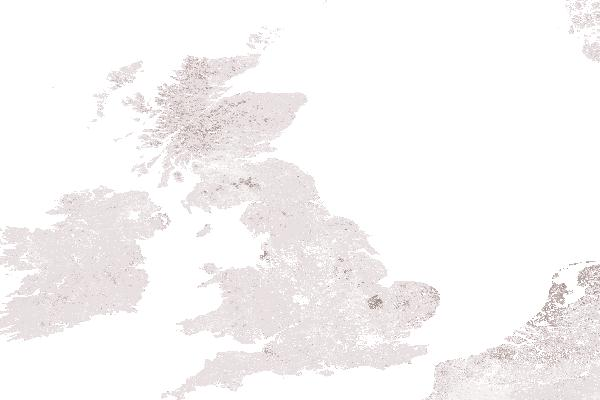

In [1]:
from owslib import wms
from IPython.display import Image
import folium
from requests import HTTPError

base_url = 'https://dev-maps.isric.org/mapserv?map=/map/ocs.map'
bounding_box = [-10, 50.0, 6, 60]

try:
    connection = wms.WebMapService(base_url, version='1.3.0')
    r = connection.getmap(
        layers=['ocs'],
        size=[600, 400],
        srs="EPSG:4326",
        bbox=bounding_box,
        format="image/jpeg")

    
    
except HTTPError as err:
    print('The ISRIC WMS Server returned the following error:')
    print('  ' + str(err))

Image(r.read())

## 2. Folium WMS request

In [2]:
m = folium.Map()
m.add_child(folium.WmsTileLayer(base_url, 'ocs'))

## 3. VRT Request

During testing, the WMS server did not always seem to be running, returning a 500 server error. An alternative method for retrieving these data is to use the virtual raster (VRT) datasets provided here: [https://files.isric.org/soilgrids/latest/data/](https://files.isric.org/soilgrids/latest/data/). These can be used in the same way as other raster files.

Text(0.5, 1.0, 'Soil organic carbon stock - UK')

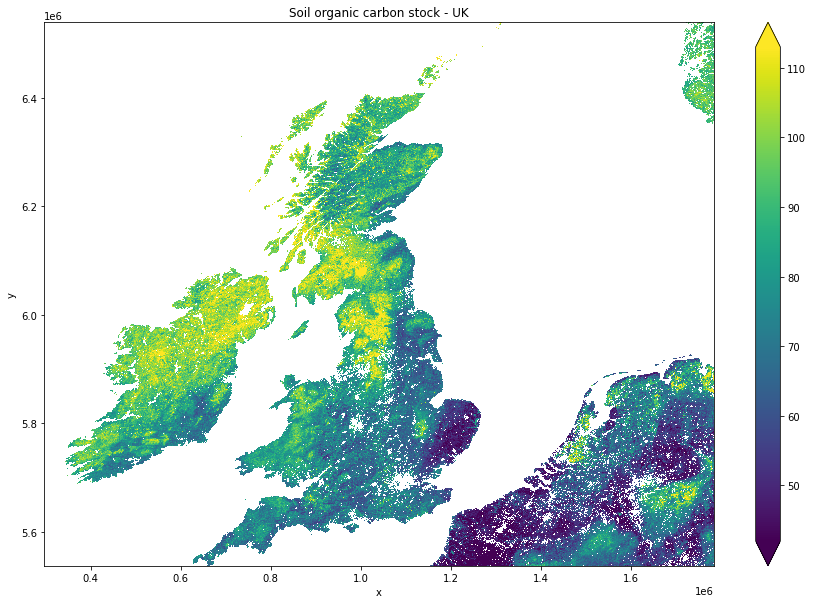

In [3]:
import xarray
import pyproj
import matplotlib.pyplot as plt

vrt_url = 'https://files.isric.org/soilgrids/latest/data/ocs/ocs_0-30cm_mean.vrt'

def load_raster(raster_path, bbox):
    """
    Loads in a VRT using a bounding box to crop
    
    Parameters
    ----------
    raster_path : str
        path to VRT or other raster dataset
    
    bbox : array-like
        4 element array with min lon, min lat, max lon, max lat
        
    Returns
    -------
    xarray.DataArray
        cropped dataset
    """
    xr = xarray.open_rasterio(raster_path)
    xr.attrs['crs'] = pyproj.CRS(xr.crs)
    # reproject bounding box
    t = pyproj.Transformer.from_crs('epsg:4326', xr.crs)
    xmi, ymi = t.transform(bbox[1], bbox[0])
    xma, yma = t.transform(bbox[3], bbox[2])
    # slice array
    xr = xr.sel(x=slice(xmi, xma), y=slice(yma,ymi))
    # mask out NA vals
    return xr.where(xr != float(xr.attrs['nodatavals'][0]))

ocs = load_raster(vrt_url, bounding_box)
ocs.plot(size=10, robust=True)
plt.title('Soil organic carbon stock - UK')